In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import (RandomForestClassifier, 
                              RandomForestRegressor,
                             GradientBoostingClassifier,
                             GradientBoostingRegressor)
from sklearn.inspection import PartialDependenceDisplay

import graphviz as gv #brew install graphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

import xgboost
import shap

from src.dagtools import (get_effect, 
                          print_dag,
                          generate_data_from_DAG)

# Explainable AI is not Causal Inference 

Explainable AI is all the rage these days. Black box ML models come along with some fun tools such as LIME, SHAP, or Partial Depence Plots that try to give visibility into how the model is interpreting data and making predictions. Many are even claiming this is causal inference - sadly we've all been mislead.

We're going to walk through an example that shows these tools fall victim to the same rules of causal inference as everything else. A confound is still a confound, and if you want to measure some causal effect there's still no way around that without careful deliberation of which variables to include in your models.

## Starting simple: Simulating some fake data

We'll simulate data from the following DAG:

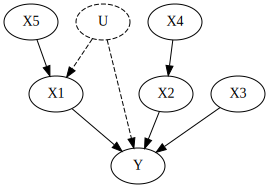

In [2]:
# 105
DAG = nx.DiGraph()
DAG.add_edge("X5", "X1")
DAG.add_edge("X1", "Y")
DAG.add_edge("U", "Y")
DAG.add_edge("U", "X1")
DAG.add_edge("X2", "Y")
DAG.add_edge("X3", "Y")
DAG.add_edge("X4", "X2")


DAG, df = generate_data_from_DAG(DAG, N=10000, seed=111)
print_dag(DAG)

---

__What's a DAG?__ A dag is a directed acyclic graph, or fancy talk for a flowchart that goes in 1 direction. It's really just a diagram of a true data generating process.

Edges in the graph are assumed to be true causal effects. So for example,

 * `X3` influences `Y`
 * `X5` influences `X1` which influences `Y`
 * Some unobserved variable `U` influences both `X1` and `Y`. By unobserved, what I mean is that its some variable we don't have data for.

For those familiar with causal inference, this DAG in particular is also riddled with confounds.

---

Ok back on track. We'll get out one of the more popular Explainable AI tools nowadays, `XGBoost`. I'm going to start the way that many in the explainable AI movement do - I'm going to toss everything in the model.

In [3]:
X = df.drop("Y",axis=1)
y = df.Y
df.head().round(3).sort_index(axis="columns")

,X1,X2,X3,X4,X5,Y
0,0.037,-1.657,-2.764,3.087,-0.701,8.996
1,0.168,-1.775,-1.907,0.014,-0.660,7.029
2,0.571,-0.844,-2.916,1.817,-0.809,7.849
3,-1.421,-1.390,-3.584,1.501,-0.307,7.808
4,1.285,-1.278,-3.366,1.072,-0.722,5.555


# Test 1: What's the impact of X1 on Y?

We know for a fact that X1 influences Y. Let's see how well Partial Dependence Plots and SHAP values do at identifying the true causal effect

In [4]:
path = nx.all_shortest_paths(DAG, "U", "Y")
# edges = [ tuple(path[i:2+i]) for i in range(len(path)-1)]

In [5]:
list( path )

[['U', 'Y']]

In [6]:
def overlay_true_effect_on_PDP(dag, feat, disp, beta=None):
    x = disp.lines_[0][0].get_xdata()
    pdp_ymean = disp.lines_[0][0].get_ydata().mean()
    
    if beta is None:
        beta = get_effect(dag, feat, "Y")
    
    yhat = x*beta
    # Scale it to have the same mean as the PDP plot
    y_scaled = yhat + (pdp_ymean - yhat.mean())

    for ax in disp.axes_.ravel():
        ax.plot(x, y_scaled,  ls="--", color="k", label="True Effect (scaled)")
#         ax.set_ylim(y_scaled.min() - 0.1, y_scaled.max() + 0.1)
        ax.legend()
    
    
def overlay_true_effect_on_shap(dag, df, feat, ax, beta=None):
    x = np.linspace(df[feat].min(), df[feat].max(), 100)
    if beta is None:
        beta = get_effect(dag, feat, "Y")
    yhat = x*beta
    ax.plot(x, yhat-yhat.mean(), color="k", label="True Effect (Scaled)", ls="--")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


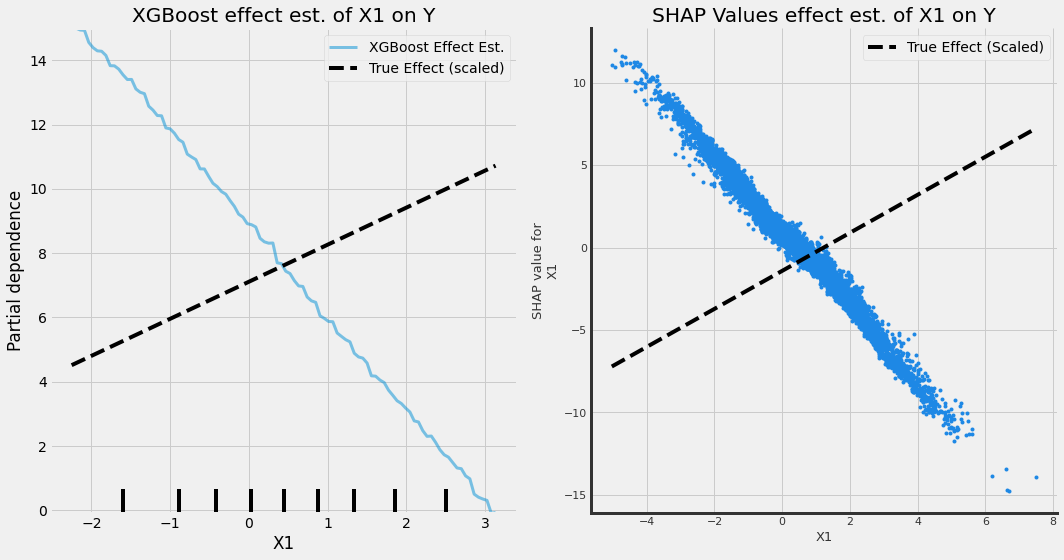

In [7]:
est = xgboost.XGBRegressor().fit(X, y)
PDP = PartialDependenceDisplay

# compute SHAP values
explainer = shap.TreeExplainer(est)
shap_values = explainer.shap_values(X)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2, figsize=(15,8)) 

# Subplot 1
ax[0].set_title("XGBoost effect est. of X1 on Y")
disp = PDP.from_estimator(
    est, 
    X=X, 
    features=["X1"],
    ax=ax[0],
    line_kw={"color":"C0", 
             "lw":3, 
             "alpha":0.5, 
             "label":"XGBoost Effect Est."}
)
overlay_true_effect_on_PDP(DAG, "X1", disp)

# Subplot 2
ax[1].set_title("SHAP Values effect est. of X1 on Y")
shap.dependence_plot("X1", shap_values, X,
                    interaction_index=None,
                    ax=ax[1], show=False, )
overlay_true_effect_on_shap(DAG, df, "X1", ax=ax[1])
ax[1].legend()

plt.tight_layout()


These SHAP values arent just wrong, but the effect is in the wrong direction. If you were to attempt to use X1 to improve Y based on this inference, the result would be a disaster and you'd make things worse.


The reason for the model getting this wrong: there's a __Fork Confound.__

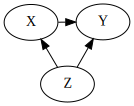

In [8]:
fork = gv.Digraph(engine="neato")
fork.edge("X", "Y")
fork.edge("Z", "X")
fork.edge("Z", "Y")

fork

Some variable `Z` confounds `X`s true effect on `Y`. 

>A very common example of a fork confound is `warm weather (Z)` on the relationship between `ice cream sales (X)` and `crime (Y)`. Ice cream sales obviously have no influence on crime, but ice cream sales are higher during warmer weather, and crime is higher during warmer weather.

So back to our main point - Explainable AI can't get around a fork confound. This is our first lesson on why SHAP / explainable AI is different from causal inference. 

Luckily in this case, causal inference can solve this problem.

Using some domain knowledge about the generating process, we notice an instrument, `X5`, that can be used to estimate the causal effect of `X1` on `Y`

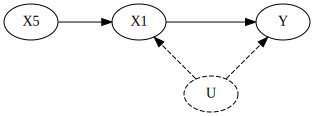

In [9]:
IV = gv.Digraph(engine="neato")
IV.edge("X5", "X1")
IV.edge("X1", "Y")
IV.edge("U", "X1", style="dashed")
IV.edge("U", "Y", style="dashed")

IV.node("U", style="dashed", pos="2,0!")
IV.node("X5", pos="-0.5,1!")
IV.node("X1", pos="1,1!")
IV.node("Y", pos="3,1!")

IV

I won't go into the details of instrumental variable analysis since the goal of this article is to highlight that Explainable AI can't replace causal inference. To learn more about it, see [Scott Cunningham's Causal Inference the Mixtape](https://mixtape.scunning.com/instrumental-variables.html?panelset=python-code&panelset1=python-code2).

But for now, I will show that a classic causal inference method succeeds where XGBoost and SHAP values fail

In [10]:
def plot_model_estimate(model, true_effect, feat, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    
    # instantiate variables for plotting readability
    est_effect=model.params.loc[feat]
    ci_est_effect = model.conf_int().loc[feat]

    # Plot effect estimate
    ax.scatter(est_effect, 0, label="Effect Est.", alpha=0.5)
    ax.hlines(0, *ci_est_effect, label="Effect Est., CI", alpha=0.5)

    # Overlay true effect
    ax.scatter(true_effect, 0, color="C1", label="True Effect", zorder=100, s=50)

    # Plot settings
    ax.set_xlabel(f"Effect of {feat} on Y")
    ax.set_yticks([]) 
    ax.legend()

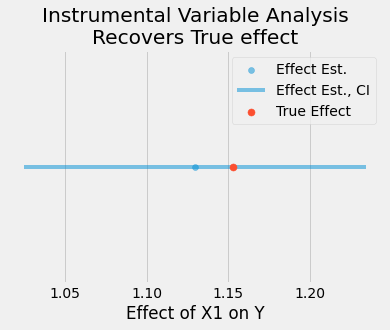

In [11]:
from linearmodels import IV2SLS
from src.dagtools import get_effect

# Instrumental variable analysis
iv_model = IV2SLS.from_formula("Y ~ 1 + [X1 ~ X5]", data=df).fit()

# pull true effect
true_effect = get_effect(DAG, "X1", "Y")

# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.set_title("Instrumental Variable Analysis\nRecovers True effect")
plot_model_estimate(iv_model, true_effect=true_effect, feat="X1", ax=ax)

# What about estimating the effect of X4 on Y?

This relationship is slightly more complicated, but certainly measurable. `X4` influences `X2` which influences `Y`. 

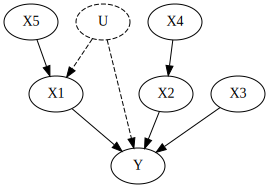

In [12]:
print_dag(DAG)

The plots below show how well explainable AI does at estimating the causal effect of this relationship. 


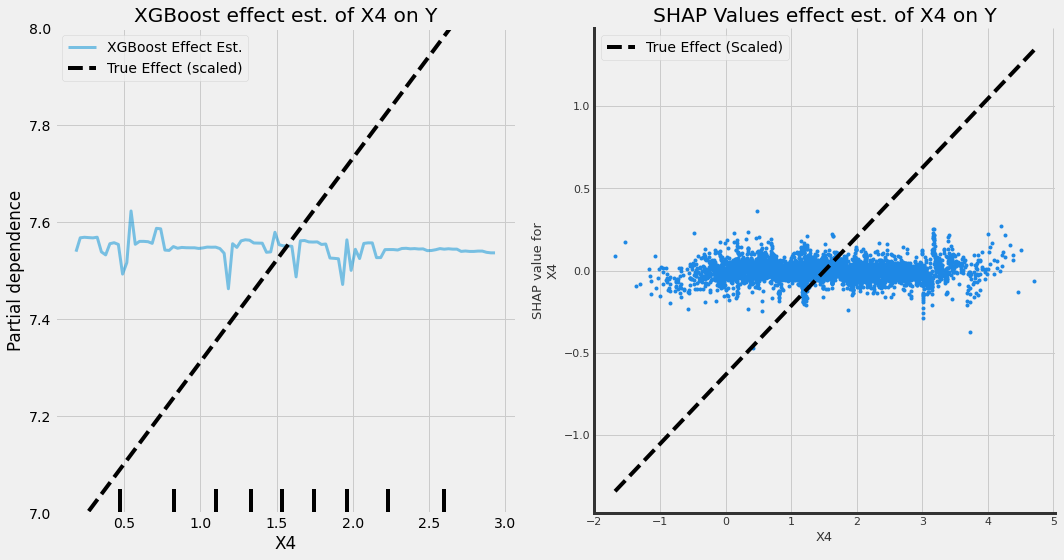

In [13]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2, figsize=(15,8)) 

true_effect = get_effect(DAG, "X4", "X2")*get_effect(DAG, "X2", "Y")

# Subplot 1
ax[0].set_title("XGBoost effect est. of X4 on Y")
disp = PDP.from_estimator(
    est, 
    X=X, 
    features=["X4"],
    ax=ax[0],
    line_kw={"color":"C0", 
             "lw":3, 
             "alpha":0.5, 
             "label":"XGBoost Effect Est."}
)
overlay_true_effect_on_PDP(DAG, "X4", disp, beta=true_effect)
disp.axes_[0][0].set_ylim(7,8)
# Subplot 2
ax[1].set_title("SHAP Values effect est. of X4 on Y")
shap.dependence_plot("X4", shap_values, X,
                    interaction_index=None,
                    ax=ax[1], show=False, )
overlay_true_effect_on_shap(DAG, df, "X4", ax=ax[1], beta=true_effect)
ax[1].legend()

plt.tight_layout()


Unfortunately, they don't pick up an effect at all! There's another simple explanation here: there's a __Pipe Confound__

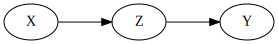

In [14]:
pipe = gv.Digraph(engine="neato")
pipe.edge("X", "Z")
pipe.edge("Z", "Y")
pipe.node("X",pos="0,1!")
pipe.node("Z",pos="1.5,1!")
pipe.node("Y",pos="3,1!")

pipe

When trying to measure the effect of `X -> Y`, conditioning on `Z` (aka including it in a model as a covariate with X) ends up blocking inference. 

For more details on how a Pipe confound works, I recommend chapters 5 and 6 of [Richard McElreath's Statistical Rethinking v2](https://xcelab.net/rm/statistical-rethinking/) (where I borrowed the example from as well).

The main things to note here are that
  1. pipe's are common
  2. Explainable AI doesn't get around them
  
You know what does get around them? Domain knowledge, deliberate selection of covariates to model, and a simple OLS estimator.

To measure the total effect of `X -> Y` including the effect through `Z`, all we have to do is use OLS regression where `Z` (the pipe) is excluded from the model.

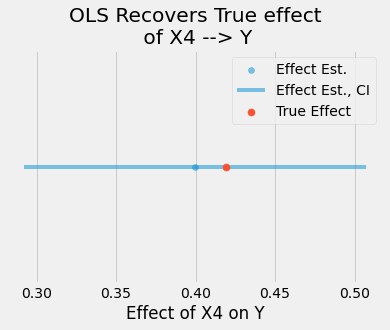

In [15]:
# Fit simple OLS model
model = sm.OLS.from_formula("Y ~ X4", data=df).fit()

# pull true effect
true_effect = get_effect(DAG, "X4", "X2") * get_effect(DAG, "X2", "Y")

# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.set_title("OLS Recovers True effect\n of X4 --> Y")
plot_model_estimate(model, true_effect=true_effect, feat="X4",ax=ax)

## Can we use Explainable AI for causal inference at all?

We can! We just need to be deliberate in which variables we include in our models, and the only way to do that right is to use DAGs! The example below looks at an XGBoost model that doesnt condition on `X2` (allowing us to estimate the causal effect of `X4 -> Y`).

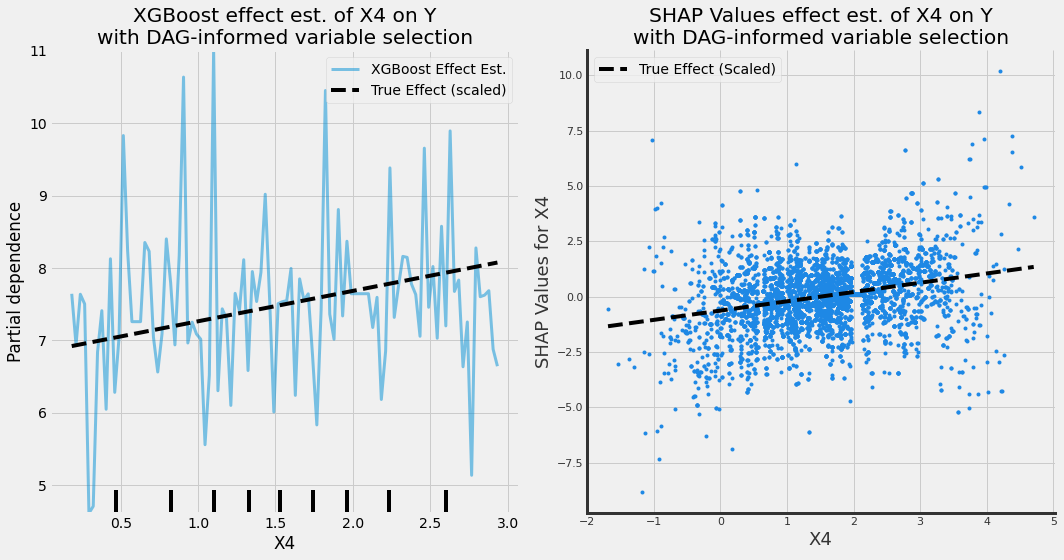

In [17]:
est2 = xgboost.XGBRegressor().fit(X[["X4"]], y)
PDP = PartialDependenceDisplay

# compute SHAP values
explainer2 = shap.TreeExplainer(est2)
shap_values2 = explainer2.shap_values(X[["X4"]])


# Plot
fig, ax = plt.subplots(1,2, figsize=(15,8)) 

true_effect = get_effect(DAG, "X4", "X2")*get_effect(DAG, "X2", "Y")

# Subplot 1
ax[0].set_title("XGBoost effect est. of X4 on Y\nwith DAG-informed variable selection")
disp = PDP.from_estimator(
    est2, 
    X=X[["X4"]], 
    features=["X4"],
    ax=ax[0],
    line_kw={"color":"C0", 
             "lw":3, 
             "alpha":0.5, 
             "label":"XGBoost Effect Est."}
)
overlay_true_effect_on_PDP(DAG, "X4", disp, beta=true_effect)

# Subplot 2
ax[1].set_title("SHAP Values effect est. of X4 on Y\nwith DAG-informed variable selection")
shap.dependence_plot("X4", shap_values2, X[["X4"]],
                    interaction_index=None,
                    ax=ax[1], show=False, )
overlay_true_effect_on_shap(DAG, df, "X4", ax=ax[1], beta=true_effect)
ax[1].legend()
ax[1].set_xlabel("X4", fontsize=18)
ax[1].set_ylabel("SHAP Values for X4", fontsize=18)

plt.tight_layout()


# Take-aways

Explainable AI is not some magic tool for causal inference. What it is good at is explaining why complicated models make the decisions they do. And with careful choice of which covariates to include in your model, they can be used for causal inference.

At the end of the day when causal inference is your goal, nothing beats using DAGs to inform deliberate variable selection.
